# Example Preprocessing Flow
- Calculate the target as % change between sucessive raw 'close' values
- Calculate moving averages (feature engineering)
- Represent the input X as a time series (data_to_supervised function)
- Train-test split and visualize

In [1]:
%load_ext autoreload
%autoreload 2
p = print

from os.path import join
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split

from crypr.transformers import MovingAverageTransformer, PercentChangeTransformer, PassthroughTransformer
from crypr.build import data_to_supervised
from crypr.util import get_project_path

coin = 'BTC'
data_path = join(get_project_path(), 'data', 'raw', coin + '.csv')

In [2]:
data = pd.read_csv(data_path, index_col=0)
p(data.shape)
data.head()

(5999, 8)


,volumeto,volumefrom,open,high,close,low,time,timestamp
0,11679250.09,1420.13,8228.41,8231.84,8196.22,8188.29,1532836800,2018-07-29 06:00:00
1,8812752.64,1072.57,8196.44,8226.30,8211.36,8190.38,1532840400,2018-07-29 07:00:00
2,7966303.56,969.86,8211.37,8214.82,8200.12,8199.24,1532844000,2018-07-29 08:00:00
3,10236329.48,1246.57,8200.12,8216.15,8178.36,8175.14,1532847600,2018-07-29 09:00:00
4,13369556.62,1637.23,8178.36,8179.49,8153.85,8134.48,1532851200,2018-07-29 10:00:00


In [3]:
preprocessing_config = {
    'passthrough': ['close', 'low', 'high'],
    'moving_average': ['close', 'volumeto', 'volumefrom'],
    'target': 'close',
    'tx': 72,
    'ty': 1,
    'test_fraction': .05,
    'truncate': (6000),
    'truncate_keep_last': True,
}
pc = preprocessing_config

In [4]:
transforms = [
    ('passthrough', PassthroughTransformer(), pc['passthrough']),
    ('ma03', MovingAverageTransformer(3), pc['moving_average']),
    ('ma06', MovingAverageTransformer(6), pc['moving_average']),
    ('ma12', MovingAverageTransformer(12), pc['moving_average']),
    ('ma24', MovingAverageTransformer(24), pc['moving_average']),
    ('ma48', MovingAverageTransformer(48), pc['moving_average']),
    ('make_target', PercentChangeTransformer(), [pc['target']]),
]
ct = ColumnTransformer(transforms, remainder='drop', n_jobs=-1)
ct = ct.fit(data)
features = ct.get_feature_names()
features

['passthrough__close',
 'passthrough__low',
 'passthrough__high',
 'ma03__close',
 'ma03__volumeto',
 'ma03__volumefrom',
 'ma06__close',
 'ma06__volumeto',
 'ma06__volumefrom',
 'ma12__close',
 'ma12__volumeto',
 'ma12__volumefrom',
 'ma24__close',
 'ma24__volumeto',
 'ma24__volumefrom',
 'ma48__close',
 'ma48__volumeto',
 'ma48__volumefrom',
 'make_target__close']

In [5]:
arr = ct.transform(data)
arr = arr[~np.isnan(arr).any(axis=1)]
arr.view()

array([[ 8.13110000e+03,  8.12034000e+03,  8.13380000e+03, ...,
         1.97005373e+07,  2.42023938e+03,  5.27882404e-02],
       [ 8.12439000e+03,  8.08844000e+03,  8.13266000e+03, ...,
         1.98267471e+07,  2.43614833e+03, -8.25226599e-02],
       [ 8.13861000e+03,  8.11744000e+03,  8.14239000e+03, ...,
         1.99794971e+07,  2.45513062e+03,  1.75028525e-01],
       ...,
       [ 4.94816000e+03,  4.91336000e+03,  4.96996000e+03, ...,
         2.37813492e+07,  4.72450792e+03,  7.08272954e-01],
       [ 4.92459000e+03,  4.92069000e+03,  4.95273000e+03, ...,
         2.34177216e+07,  4.65124729e+03, -4.76338679e-01],
       [ 4.92677000e+03,  4.92358000e+03,  4.93127000e+03, ...,
         2.24633220e+07,  4.46135667e+03,  4.42676446e-02]])

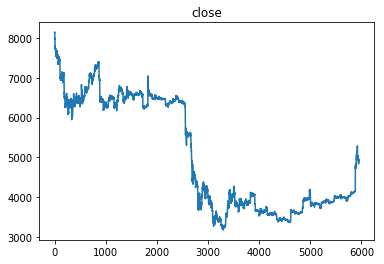

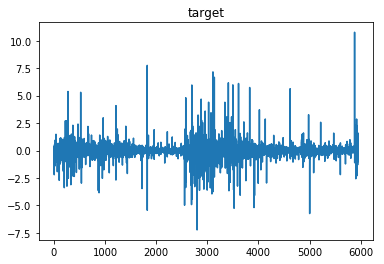

In [6]:
plt.figure(); plt.plot(arr[:, features.index('passthrough__close')]); plt.title('close')
plt.figure(); plt.plot(arr[:, features.index('make_target__close')]); plt.title('target')
# plt.figure(); plt.plot(df.filter(regex='v(t|f)')); plt.title('v(t|f)')
plt.show()

In [7]:
num_features = arr.shape[1] - pc['ty']
p('Number of Unique Features:', num_features)
p('Number of Hours per Sample:', pc['tx'])
p('Total Features per Sample:', pc['tx']*num_features)

Number of Unique Features: 18
Number of Hours per Sample: 72
Total Features per Sample: 1296


In [8]:
X, y = data_to_supervised(input_df=arr, target_ix=-1, Tx=pc['tx'], Ty=pc['ty'])
p(X.head(2))
p(y.head(5))

    var1(t-72)  var2(t-72)  var3(t-72)   var4(t-72)    var5(t-72)  \
72     8131.10     8120.34     8133.80  8126.856667  1.169669e+07   
73     8124.39     8088.44     8132.66  8127.433333  1.314026e+07   

     var6(t-72)   var7(t-72)    var8(t-72)  var9(t-72)  var10(t-72)  ...  \
72  1434.026667  8142.016667  1.678302e+07    2053.915  8104.939167  ...   
73  1613.140000  8135.195000  1.473532e+07    1806.600  8104.979167  ...   

     var10(t-1)    var11(t-1)   var12(t-1)   var13(t-1)    var14(t-1)  \
72  7498.734167  2.292557e+07  3060.597500  7552.270417  1.981683e+07   
73  7482.529167  2.294011e+07  3066.153333  7539.219583  1.986820e+07   

     var15(t-1)   var16(t-1)    var17(t-1)   var18(t-1)  var19(t-1)  
72  2625.869583  7568.170833  2.118826e+07  2798.270000    0.154711  
73  2635.506667  7563.776250  2.087315e+07  2757.428958   -0.291283  

[2 rows x 1368 columns]
     var1(t)
72 -0.291283
73  0.360807
74 -0.445993
75  0.457128
76  0.426811


In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=pc['test_fraction'], shuffle=False)
p('Train shape: ', X_train.shape)
p('Test shape: ', X_test.shape)

Train shape:  (5586, 1368)
Test shape:  (294, 1368)


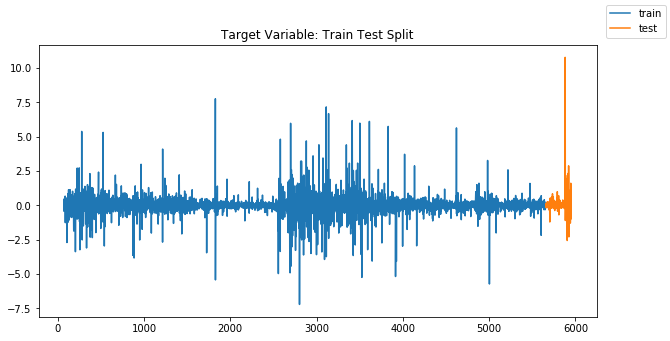

In [10]:
fig, ax = plt.subplots(1, figsize=(10, 5))
ax.plot(y_train, label='train')
ax.plot(y_test, label='test')
plt.title('Target Variable: Train Test Split')
fig.legend()
plt.show()